# Spatially variable genes
```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: spatial-spatially-variable-genes-key-takeaway-1
:link-type: ref
Spatially variable genes (SVGs) are genes that show a significant spatial pattern.
:::

:::{card}
:link: spatial-spatially-variable-genes-key-takeaway-2
:link-type: ref
Methods designed for this task vary in complexity and model assumptions.
:::

:::{card}
:link: spatial-spatially-variable-genes-key-takeaway-3
:link-type: ref
We recommend using multiple methods to identify SVGs and assess the result by plotting the gene's expression in space.
:::

```
``````{dropdown} <i class="fa-solid fa-gear"></i>   Environment setup
`````{tab-set}

````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} spatial.yml
:language: yaml
```
````

`````
``````
<!-- END DROPDOWNS -->

(spatial-spatially-variable-genes-key-takeaway-1)=
(spatial-spatially-variable-genes-key-takeaway-2)=
(spatial-spatially-variable-genes-key-takeaway-3)=
## Motivation

One main analysis step for single-cell data is to identify highly-variable genes (HVGs) and perform feature selection to reduce the dimensionality of the dataset. HVGs are genes which show significantly different expression profiles between cells or distinct groups. Methods designed for this task, however, neglect the spatial context of cells and can therefore not identify spatial variation. A gene might for example be highly variable, but not show a distinct spatial pattern and is therefore not spatially variable. 

:::{figure-md} svg

<img src="../_static/images/spatial/svg.jpeg" alt="Difference highly variable gene versus spatially variable gene" class="bg-primary mb-1" width="800px">

Spatially variable genes are genes that show a distinct spatial pattern, whereas highly variable genes reflect genes that differ significantly between cells or groups of cells. 
:::


Spatial variation can be caused by differences in cell-type composition, overall functional dependencies or cell-cell communication events and help to understand the underlying tissue biology. Methods designed to identify spatially variable genes (SVGs) are designed to quantify whether a gene shows a significant spatial pattern by typically decomposing spatial and non-spatial variation in the dataset {cite}`walker_deciphering_2022`. 

Several methods have been proposed for this task with varying complexity and different assumptions. Currently there is no consensus on which method works best and how to define spatial variability in general. SpatialDE {cite}`svensson_spatialde_2018`, SpatialDE2 {cite}`kats_spatialde2_2021` and SPARK{cite}`zhu_spark-x_2021` {cite}`sun_statistical_2020` use spatial correlation testing, Sepal{cite}`andersson_sepal_2021` leverages a Gaussian diffusion on spatial expression, scGCO{cite}`zhang_identification_2022` utilizes a graph cut method and SpaGCN {cite}`Hu2021-SpaGCN` identifies SVGs based on spatial domains identified through a graph convolutional neural network.

In this notebook we provide a pedagogical example using Squidpy {cite}`Palla2022` and its implementation of Morans'I to find SVGs and subsequently an example workflow for SpatialDE. 


## Environment setup and data

We first load the respective packages needed in this tutorial and the dataset.

In [1]:
import NaiveDE
import scanpy as sc
import SpatialDE
import squidpy as sq

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

The dataset used in this tutorial consists of 1 tissue slides from 1 mouse and is provided by [10x Genomics Space Ranger 1.1.0](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Adult_Mouse_Brain). The dataset was pre-processed in Squidpy, which provides a loading function for this dataset. 

In [2]:
adata = sq.datasets.visium_hne_adata()

## Moran's I score in Squidpy

One approach for the identification of spatially variable genes is the Moran's I score, a measure of spatial autocorrelation (correlation of signal, such as gene expression, in observations close in space).

It is defined as:
$I = \frac{n}{W}\frac{{\mathop {\sum }\nolimits_{i = 1}^n \mathop {\sum }\nolimits_{j = 1}^n w_{i,j}z_iz_j}}{{\mathop {\sum }\nolimits_{i = 1}^n z_i^2}}$
where 
- $z_{i}$ is the deviation of the feature from the mean $\left( {x_i - \bar X} \right)$
- $w_{i,j}$ is the spatial weight between observations
- $n$ is the number of spatial units
- $W$ is the sum of all $w_{i,j}$

It can be computed with Squidpy with 1 line. For the purpose of the example, we will compute it only for a few genes. 

In [3]:
sq.gr.spatial_neighbors(adata)
sq.gr.spatial_autocorr(adata, mode="moran", genes=adata.var_names)

Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `None` permutations using `1` core(s)
Adding `adata.uns['moranI']`
Finish (0:00:00)


The method adds a dataframe to `adata.uns` under the key `moranI`. We can inspect the result now:

In [4]:
adata.uns["moranI"].head()

,I,pval_norm,var_norm,pval_norm_fdr_bh
Nrgn,0.874753,0.0,0.000131,0.0
Mbp,0.868723,0.0,0.000131,0.0
Camk2n1,0.866542,0.0,0.000131,0.0
Slc17a7,0.861761,0.0,0.000131,0.0
Ttr,0.841986,0.0,0.000131,0.0


The Squidpy implementation of Moran's I computed for every gene 

* `I` so the Moran’s I,

* `pval_norm` a p-value under normality assumption.

* `var_norm` the variance of the Moran's I under normality assumption.

* `{p_val}_{corr_method}` the corrected p-values.

Let us look at two of the identified and significant genes, for example *Nrgn* and *Ttr* with corrected p-values of 0.0.

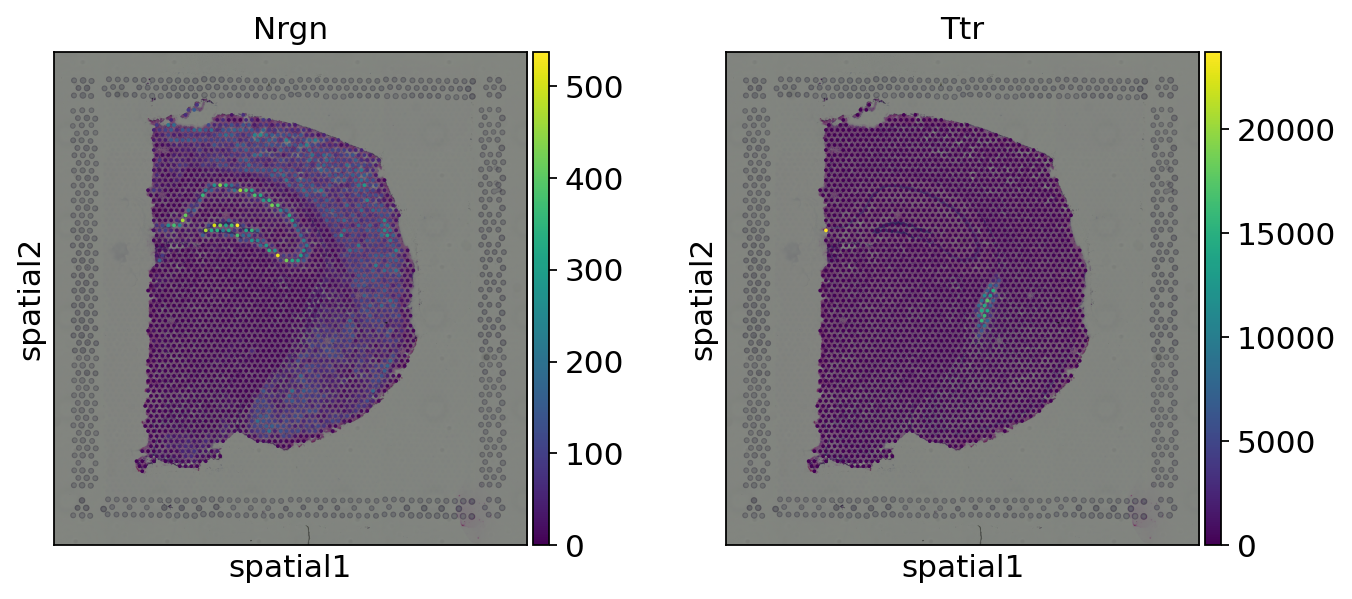

In [5]:
sq.pl.spatial_scatter(adata, color=["Nrgn", "Ttr"])

We can see that the expression of both of these genes seems to show a distinct localization in the tissue. It should be noted that they might (or might not) be also marker genes for specific cell clusters. One interpretation of spatially variable genes identification is that it is an orthogonal way to perform feature selection, by selecting genes that show a variability in space (instead of, for instance, across observations, as it is usually done).


## SpatialDE

SpatialDE identifies spatial variable genes through Gaussian process regression. The spatial method decomposes each gene's expression variability into a spatial and nonspatial component. It then computes the ratio between the spatial and nonspatial variance term to quantify the overall spatial variance present in the dataset. In order to identify significant spatially variable genes, SpatialDE compares the full model that has access to the spatial component to a model without this term.

We are using the same dataset as we did for computing Moran's I. As SpatialDE requires the counts table saved as a DataFrame with unique variable names, we first make all variable names unique with the help of the respective Scanpy function.


In [6]:
adata.var_names_make_unique()

Next, we collect the raw count table with all barcode names and variable names saved as dataframe indexes and columns. Scanpy provides an efficient function for this, `get.obs_df` which collects the respective keys stored in `adata`.

In [7]:
counts = sc.get.obs_df(adata, keys=list(adata.var_names), use_raw=True)

SpatialDE additionally requires the total counts and the spatial coordinates in the form of a DataFrame. We can use the same Scanpy function of collecting these items as before. 

In [8]:
total_counts = sc.get.obs_df(adata, keys=["total_counts"])

SpatialDE assumes a normally distributed noise. Since we just extracted raw counts, which empirically follow a negative binomial distribution, the counts data first needs to be transformed to a normal distributed noise. For this purpose SpatialDE uses a technique based on Anscombe:

In [9]:
norm_expr = NaiveDE.stabilize(counts.T).T

/home/icb/anna.schaar/miniconda3/envs/spatial-chapters/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


The transformed data still might include a varying library size across the spatial samples which can introduce a bias in the gene expression. SpatialDE recommends to account for this before actually performing the spatial test and regressing it out with the provided function:

In [10]:
resid_expr = NaiveDE.regress_out(total_counts, norm_expr.T, "np.log(total_counts)").T

We can now run the actual spatial test by passing the spatial coordinates and the normalized counts to SpatialDE. On the dataset, we are using here SpatialDE takes roughly 15 minutes when running it on all genes. 

In [11]:
results = SpatialDE.run(adata.obsm["spatial"], resid_expr)

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/18078 [00:00<?, ?it/s]

  0%|          | 0/18078 [00:00<?, ?it/s]

  0%|          | 0/18078 [00:00<?, ?it/s]

  0%|          | 0/18078 [00:00<?, ?it/s]

  0%|          | 0/18078 [00:00<?, ?it/s]

  0%|          | 0/18078 [00:00<?, ?it/s]

  0%|          | 0/18078 [00:00<?, ?it/s]

  0%|          | 0/18078 [00:00<?, ?it/s]

  0%|          | 0/18078 [00:00<?, ?it/s]

  0%|          | 0/18078 [00:00<?, ?it/s]

We can now inspect the result:

In [12]:
results.head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
0,1.065401e-01,4,Mrpl15,68.5,8.383709e+00,-2836.151268,-8.553531,7.251817e+00,SE,2688,0.004038,3.928962e-01,0.009583,5703.888747,-2836.979729,0.828461,0.362718,0.462134
1,1.132153e-06,4,4732440D04Rik,68.5,8.830160e+05,1005.684545,-0.849110,8.478789e-07,SE,2688,0.043424,2.453021e+10,0.001693,-1979.782879,1005.684446,0.000099,0.992065,0.992308
2,2.556985e-01,4,Rrs1,68.5,2.910013e+00,-2372.430346,-5.025306,5.476694e+00,SE,2688,0.001739,5.062643e-02,0.003723,4776.446902,-2376.942619,4.512274,0.033652,0.056698
3,2.492298e-01,4,Cops5,68.5,3.011488e+00,-2579.842074,-11.139282,2.601672e+01,SE,2688,0.001748,5.234926e-02,0.003669,5191.270360,-2584.203162,4.361088,0.036769,0.061422
4,2.060557e-09,4,Cpa6,68.5,4.851652e+08,2817.673512,-0.768099,1.230862e-09,SE,2688,0.031727,5.410451e+15,0.001641,-5603.760814,2817.673419,0.000093,0.992305,0.992308


The resulting DataFrame contains the following important columns:

* `g`, the gene name
* `l`, a parameter indicating the genes distance scale a gene changes expression over
* `pval`, the p-value for spatial differential expression
* `qval`, the corrected p-value after correcting for multiple testing

We can now sort the result based on the corrected p-values (`qval`) and to better read the DataFrame, subset the table to only show `g`, `l` and `qval`. We will additionally save the object as `top10` to conveniently use it for downstream plotting.

In [17]:
top10 = results.sort_values("qval").head(10)[["g", "l", "qval"]]
top10

,g,l,qval
7612,Esrra,443.950519,0.0
6586,Fbxo31,443.950519,0.0
6587,Jph3,443.950519,0.0
6588,Rpl13,443.950519,0.0
6589,Cpne7,443.950519,0.0
6590,Spata2l,443.950519,0.0
6591,Tcf25,443.950519,0.0
6592,Tubb3,443.950519,0.0
6593,Rhou,443.950519,0.0
6594,2810455O05Rik,443.950519,0.0


We can now plot the top-three significant genes and inspect their spatial pattern. We additionally plot the clusters of the dataset to analyze whether the detected genes might be linked to specific clusters. 

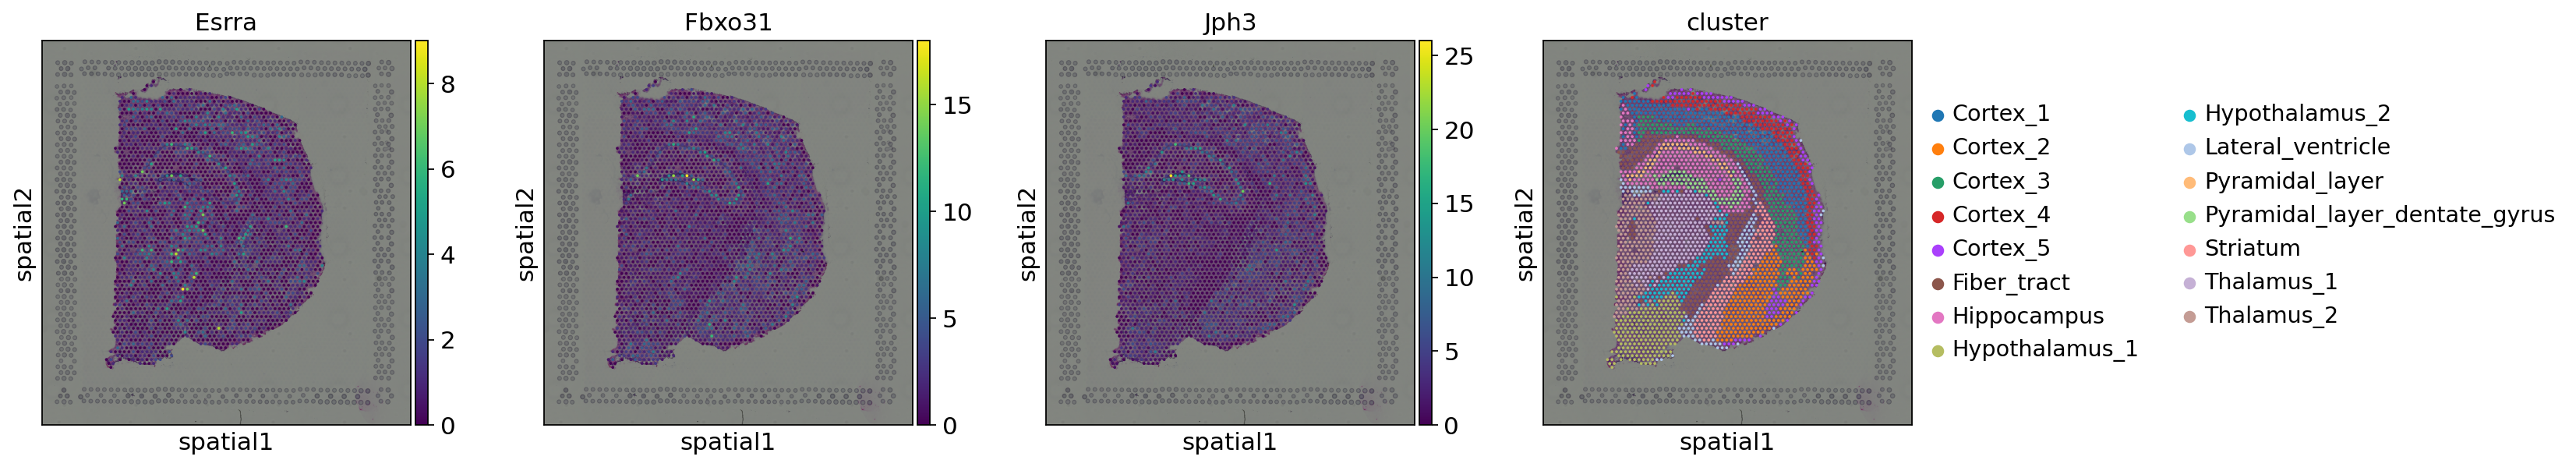

In [21]:
sq.pl.spatial_scatter(adata, color=list(top10["g"][:3]) + ["cluster"])

As we can observe, all three genes show spatial patterns. *Esrra* does not seem to be associated with a specific cluster, but shows a spatial pattern in primarily the cortex layers, the thalamus and hypothalamus. *Fbxo31* and *Jph3* are primarily expressed in the pyramidal layer. 

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: spatial
```

## Contributors
### Authors
* Giovanni Palla
* Anna Schaar

### Reviewers
* Lukas Heumos